In [1]:
import sys
sys.path.append('/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic')
sys.path.append('/home/g201381710/.local/lib/python3.10/site-packages')

sys.path

['/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic/dotless_arabic/analysis/notebooks',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/g201381710/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/g201381710/.ipython',
 '/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic',
 '/home/g201381710/.local/lib/python3.10/site-packages']

In [2]:
import math
import random

from collections import Counter
from functools import lru_cache

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pylab as plt
from scipy.stats import linregress

from dotless_arabic.processing import process,undot

from dotless_arabic.datasets.news.collect import collect_raw_dataset as collect_raw_news_dataset
from dotless_arabic.datasets.quran.collect import collect_raw_dataset as collect_raw_quran_dataset
from dotless_arabic.datasets.poems.collect import collect_raw_dataset as collect_raw_poems_dataset
from dotless_arabic.datasets.wikipedia.collect import collect_raw_dataset as collect_raw_wikipedia_dataset
from dotless_arabic.datasets.sanadset_hadeeth.collect import collect_raw_dataset as collect_raw_hadeeth_dataset
from dotless_arabic.datasets.aggregated.collect import collect_raw_dataset as collect_raw_aggregated_dataset

In [3]:
random.seed(42)

# functions

In [4]:
@lru_cache()
def characters_counter(dataset):
  return Counter(character for item in tqdm(dataset) for character in list(item))

@lru_cache()
def words_counter(dataset,use_tqdm=True):
    if not use_tqdm:
        return Counter(word for item in dataset for word in item.split())    
    return Counter(word for item in tqdm(dataset) for word in item.split())

In [5]:
@lru_cache()
def undot_dataset(dataset):
    return list(map(undot, tqdm(dataset)))

@lru_cache()
def process_dataset(dataset):
    return list(map(process, tqdm(dataset)))

In [6]:
poems = list()
for poem in tqdm(collect_raw_poems_dataset()['poem verses']):
    poems.extend(poem)
poems = list(set(poems))

Using custom data configuration MagedSaeed--ashaar-719bb58a76ea0092
Found cached dataset parquet (/home/g201381710/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/254630 [00:00<?, ?it/s]

In [7]:
datasets = [
    process_dataset(dataset=tuple(collect_raw_quran_dataset())),
    process_dataset(dataset=tuple(collect_raw_hadeeth_dataset())),
    process_dataset(dataset=tuple(poems)),
    process_dataset(dataset=tuple(collect_raw_wikipedia_dataset())),
    process_dataset(dataset=tuple(collect_raw_news_dataset())),
    process_dataset(dataset=tuple(collect_raw_aggregated_dataset())),
]

# shuffle datasets
for dataset in datasets:
    random.shuffle(dataset)

datasets_names = [
    'quran',
    'sanadset hadeeth',
    'poems',
    'wikipedia',
    'news',
    'aggregated',
]

  0%|          | 0/6236 [00:00<?, ?it/s]

####################################################################################################
Original Number of Samples:
650,986
####################################################################################################
####################################################################################################
Number of Samples after dropping duplicates:
637,565
####################################################################################################


  0%|          | 0/637565 [00:00<?, ?it/s]

  0%|          | 0/7152063 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:00<?, ?it/s]

  0%|          | 0/2784041 [00:00<?, ?it/s]

Using custom data configuration MagedSaeed--ashaar-719bb58a76ea0092
Found cached dataset parquet (/home/g201381710/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/254630 [00:00<?, ?it/s]

####################################################################################################
Original Number of Samples:
650,986
####################################################################################################
####################################################################################################
Number of Samples after dropping duplicates:
637,565
####################################################################################################


  0%|          | 0/15779363 [00:00<?, ?it/s]

In [8]:
# we may need to report the error on the regression line: MSE, MAE, etc.
def get_heaps_law_constants(dataset,n_points=500,get_points_list=False,clear_lru_cache=False):
  X,Y = [],[]
  vocabulary = set()
  number_of_tokens = 0
  for index in tqdm(range(
      0,
      len(dataset),
      len(dataset)//n_points
    )):
    if index==0:
      continue
    
    counter = words_counter(
        tuple(dataset[index-(len(dataset)//n_points):index]),
        use_tqdm=False,
    )
    
    number_of_tokens += sum(counter.values())
    X.append(
        math.log(
            number_of_tokens,
            10, #base
          ),
      )
    
    vocabulary.update(counter.keys())
    Y.append(
        math.log(
            len(vocabulary),
            10, #base
          ),
      )
    
    if clear_lru_cache:
      words_counter.cache_clear()
    
  slope,intercept,*_= linregress(X,Y)

  b = slope
  k = 10**intercept

  if get_points_list:
    return b,k,(X,Y)
  return b,k

In [9]:
get_heaps_law_constants(dataset=datasets[0])

  0%|          | 0/520 [00:00<?, ?it/s]

(0.7064909741622981, 5.437988311767651)

In [71]:
def plot_heaps(
    datasets=datasets,
    datasets_names=datasets_names,
    figsize=(25,12),
  ):

  unlog = lambda points: list(map(lambda point: 10**point,points))

  plt.figure(figsize=figsize)
    
  for dataset,dataset_name in zip(datasets,datasets_names):
        
      beta,k,(X,Y) = get_heaps_law_constants(dataset,get_points_list=True)
      print()
      print('-'*100)
      print('-'*100)
      print('beta: ',beta,' k ',k,' for dataset: ',dataset_name)

      print('some samples of the dotted X,Y lists:')  
      print(list(map(lambda item: round(item,2),unlog(X[:10]))))
      print(list(map(lambda item: round(item,2),unlog(Y[:10]))))
    
      undotted_dataset = undot_dataset(dataset=tuple(dataset))
      undotted_beta,undotted_k,(undotted_X,undotted_Y) = get_heaps_law_constants(undotted_dataset,get_points_list=True)
      print('-'*100)
      print('undotted beta: ',undotted_beta,' undotted k ',undotted_k, ' for dataset: ',dataset_name)
      print('-'*100)
      print('-'*100)
      print()
       
      plt.plot(unlog(X),unlog(Y),label=f'{dataset_name} dataset (k={k:.3f},β={beta:.3f})')
      # https://stackoverflow.com/a/41308516/4412324
      # plt.text(
      #     x=0.73,
      #     y=0.95,
      #     s=f'dotted: k={k:.3f},β={beta:.3f}',
      #     transform=plt.gca().transAxes,
      #     fontsize=12,
      # )
    
      plt.plot(unlog(undotted_X),unlog(undotted_Y),label=f'undotted {dataset_name} dataset (k={undotted_k:.3f},β={undotted_beta:.3f})')
        
      # plt.text(
      #     x=0.73,
      #     y=0.92,
      #     s=f'undotted: k={undotted_k:.3f},β={undotted_beta:.3f}',
      #     transform=plt.gca().transAxes,
      #     fontsize=12,
      # )
    
      plt.legend(loc='upper left',fontsize=12)
      plt.ylim(ymin=0)
      plt.xlim(xmin=0)
      # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
      plt.xticks(fontsize=12)
      plt.yticks(fontsize=12)
      # https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib
      # https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
      plt.rc('font',size=11)

  0%|          | 0/520 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.7064909741622981  k  5.437988311767651  for dataset:  quran
some samples of the dotted X,Y lists:
[158.0, 337.0, 506.0, 667.0, 869.0, 1024.0, 1137.0, 1273.0, 1440.0, 1584.0]
[129.0, 242.0, 349.0, 438.0, 552.0, 643.0, 709.0, 775.0, 863.0, 926.0]


  0%|          | 0/520 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.6959689064992671  undotted k  5.832499940083151  for dataset:  quran
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



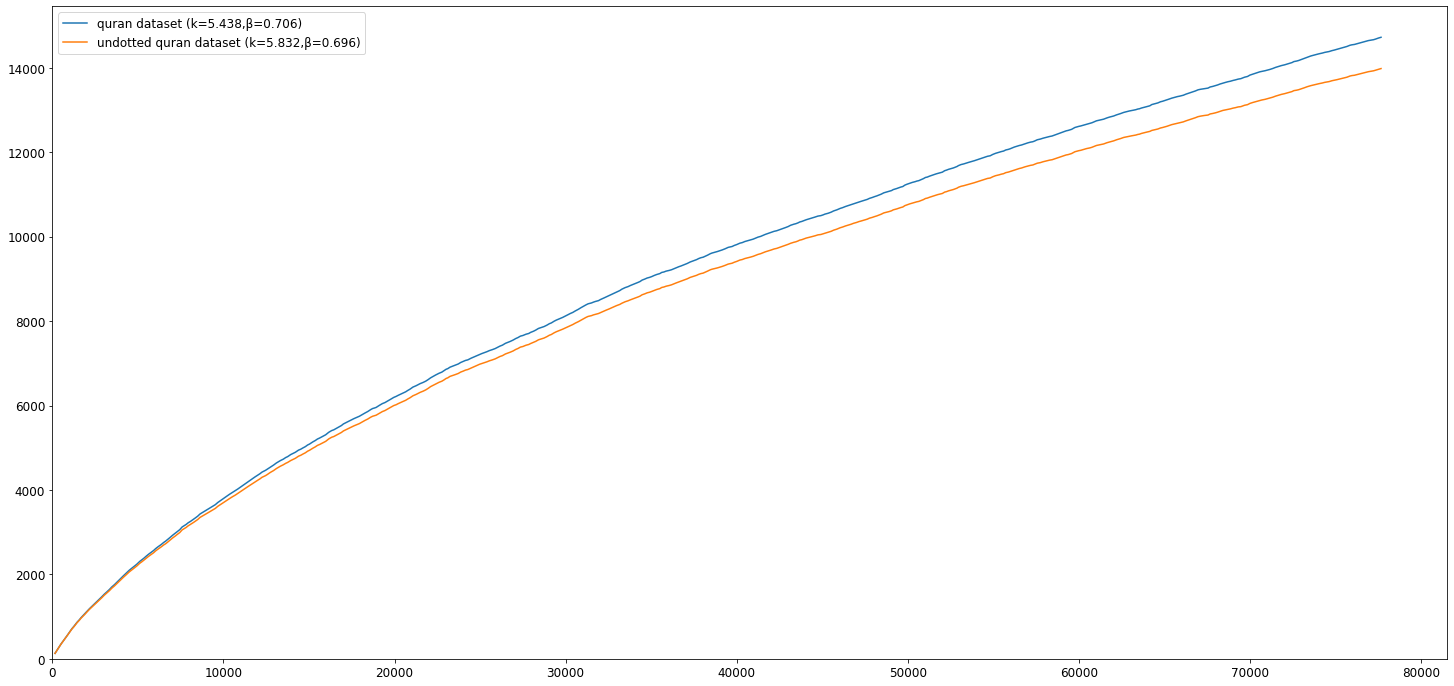

In [72]:
plot_heaps(
    datasets=[datasets[0]],
    datasets_names=[datasets_names[0]],
)

  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.4941859529083958  k  159.50300664612868  for dataset:  aggregated
some samples of the dotted X,Y lists:
[740604.0, 1489119.0, 2233652.0, 2987994.0, 3739946.0, 4497770.0, 5249425.0, 6004590.0, 6765859.0, 7512146.0]
[108986.0, 163062.0, 204966.0, 240454.0, 271232.0, 299713.0, 325215.0, 349411.0, 371748.0, 392797.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.472815747652509  undotted k  184.6250306203151  for dataset:  aggregated
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.44301124400830333  k  226.8576321089664  for dataset:  news
some samples of the dotted X,Y lists:
[267327.0, 537229.0, 807675.0, 1081677.0, 1353743.0, 1621765.0, 1889101.0, 2158029.0, 2429662.0, 2701551.0]
[47186.0, 69152.0, 86341.0, 100362.0, 112399.0, 122809.0, 132246.0, 141142.0, 149644.0, 157363.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.4205990214229171  undotted k  281.780799742258  for dataset:  news
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.5274300802521817  k  80.63244654150975  for dataset:  wikipedia
some samples of the dotted X,Y lists:
[347365.0, 699175.0, 1053866.0, 1408725.0, 1761417.0, 2116401.0, 2473304.0, 2830641.0, 3185853.0, 3536574.0]
[59157.0, 90727.0, 115324.0, 136169.0, 154708.0, 171634.0, 187205.0, 201532.0, 214880.0, 227906.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.5079759307469488  undotted k  94.8732199732732  for dataset:  wikipedia
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.5088134272845436  k  157.1978745643671  for dataset:  poems
some samples of the dotted X,Y lists:
[65767.0, 131829.0, 197799.0, 263659.0, 329471.0, 395493.0, 461498.0, 527122.0, 593020.0, 659044.0]
[28729.0, 47644.0, 63026.0, 76379.0, 88274.0, 99070.0, 109119.0, 118575.0, 127365.0, 135913.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.4717960575102139  undotted k  210.4476546585908  for dataset:  poems
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/501 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.45473481433997776  k  133.8736068364392  for dataset:  sanadset hadeeth
some samples of the dotted X,Y lists:
[60544.0, 120003.0, 177291.0, 230255.0, 289961.0, 350759.0, 417190.0, 478424.0, 535534.0, 595950.0]
[12179.0, 19801.0, 25492.0, 30163.0, 34960.0, 39452.0, 43986.0, 47718.0, 50756.0, 54001.0]


  0%|          | 0/501 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.42766187380929727  undotted k  170.70759476379504  for dataset:  sanadset hadeeth
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



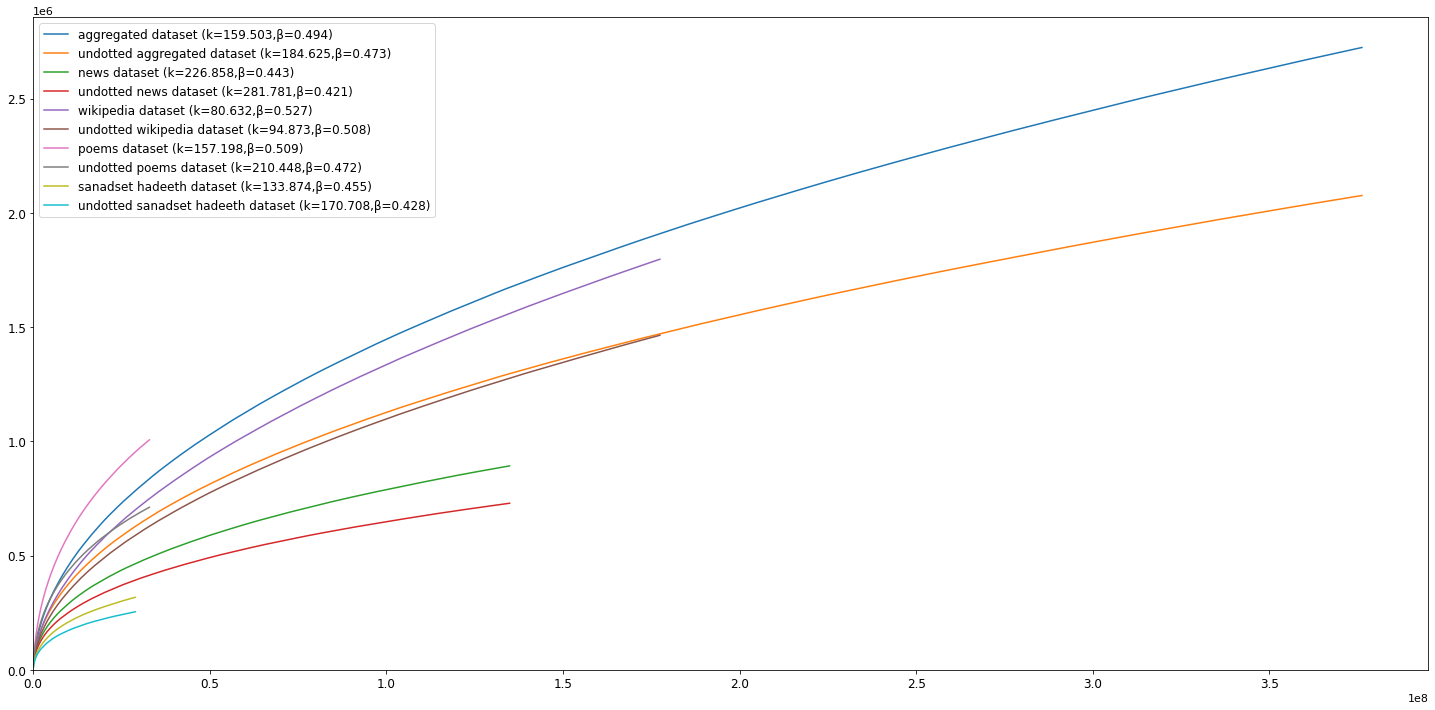

In [73]:
plot_heaps(
    datasets=[datasets[5],datasets[4],datasets[3],datasets[2],datasets[1]],
    datasets_names=[datasets_names[5],datasets_names[4],datasets_names[3],datasets_names[2],datasets_names[1]],
)